# Digital Signal and Image Management
###### Image Recognition

> **Cognome**: Filosa    **Nome**: Alberto                                  \\
> **Matricola**: 815589                                                     \\
> **Anno Accademico**: 2020/2021                                            \\
> **Facoltà**: Dipartimento di Informatica, Sistemi e Comunicazione (DISCO) \\
> **Corso di Laurea Magistrale**: Data Science                              \\
> **e-mail**: a.filosa1@campus.unimib.it                                    \\

> **Cognome**: Sofia    **Nome**: Davoli                                  \\
> **Matricola**: 813479                                                     \\
> **Anno Accademico**: 2020/2021                                           \\
> **Facoltà**: Dipartimento di Informatica, Sistemi e Comunicazione (DISCO) \\
> **Corso di Laurea Magistrale**: Data Science                              \\
> **e-mail**: s.davoli1@campus.unimib.it                                    \\

# Libraries

In [ ]:
import matplotlib.pyplot as plt
import cv2 as cv
import seaborn as sns
%matplotlib inline
import numpy as np
import pandas as pd
sns.set()
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  *
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.applications import DenseNet121, VGG19, ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import PIL.Image
import matplotlib.pyplot as mpimg
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.preprocessing import image

from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle
from shutil import copyfile #-- Copy Files
import zipfile #-- Extract Zip Files

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


# Read Files

In [ ]:
xray = "/content/gdrive/MyDrive/Università/Data Science/2° Anno/Digital Signal and Image Management/Progetto DSIM/image_covid.zip"

In [ ]:
copyfile(xray, 'image_covid.zip')             #-- Copy File Audio

zip = zipfile.ZipFile('image_covid.zip', 'r') #-- Open File
zip.extractall()                              #-- Extract Files
zip.close()                                   #-- Close Files

In [ ]:
train_df = pd.read_csv('Chest_xray_Corona_Metadata.csv')
train_df.shape

(5910, 6)

In [ ]:
train_df.head()

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5910 entries, 0 to 5909
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Unnamed: 0              5910 non-null   int64 
 1   X_ray_image_name        5910 non-null   object
 2   Label                   5910 non-null   object
 3   Dataset_type            5910 non-null   object
 4   Label_2_Virus_category  69 non-null     object
 5   Label_1_Virus_category  4334 non-null   object
dtypes: int64(1), object(5)
memory usage: 277.2+ KB


# Explanatory Analysis

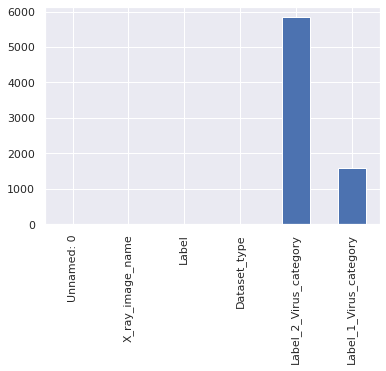

In [ ]:
missing_vals = train_df.isnull().sum()
missing_vals.plot(kind = 'bar')

In [ ]:
train_df.dropna(how = 'all') #-- Drop NA
train_df.isnull().sum()

Unnamed: 0                   0
X_ray_image_name             0
Label                        0
Dataset_type                 0
Label_2_Virus_category    5841
Label_1_Virus_category    1576
dtype: int64

In [ ]:
train_df.fillna('unknown',      #-- Fill NA with Unknwon
                inplace = True)
train_df.isnull().sum()         #-- Check NA

Unnamed: 0                0
X_ray_image_name          0
Label                     0
Dataset_type              0
Label_2_Virus_category    0
Label_1_Virus_category    0
dtype: int64

In [ ]:
train_data = train_df[train_df['Dataset_type'] == 'TRAIN'] #-- Select Train Rows
test_data = train_df[train_df['Dataset_type'] == 'TEST']   #-- Select Test Rows

assert train_data.shape[0] + test_data.shape[0] == train_df.shape[0]
print(f"Shape of train data : {train_data.shape}")
print(f"Shape of test data : {test_data.shape}")
test_data.sample(5)

Shape of train data : (5286, 6)
Shape of test data : (624, 6)


,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
5727,5750,person92_bacteria_450.jpeg,Pnemonia,TEST,unknown,bacteria
5310,5333,NORMAL2-IM-0045-0001.jpeg,Normal,TEST,unknown,unknown
5573,5596,person147_bacteria_705.jpeg,Pnemonia,TEST,unknown,bacteria
5701,5724,person103_bacteria_488.jpeg,Pnemonia,TEST,unknown,bacteria
5748,5771,person85_bacteria_421.jpeg,Pnemonia,TEST,unknown,bacteria


In [ ]:
train_df["Label"].value_counts()

Pnemonia    4334
Normal      1576
Name: Label, dtype: int64

In [ ]:
print((train_df['Label_1_Virus_category']).value_counts())
print('--------------------------')
print((train_df['Label_2_Virus_category']).value_counts())

bacteria          2777
unknown           1576
Virus             1555
Stress-Smoking       2
Name: Label_1_Virus_category, dtype: int64
--------------------------
unknown          5841
COVID-19           58
Streptococcus       5
SARS                4
ARDS                2
Name: Label_2_Virus_category, dtype: int64


In [ ]:
train_df[train_df["Label"] == "Pnemonia"]["Label_1_Virus_category"].value_counts()

bacteria          2777
Virus             1555
Stress-Smoking       2
Name: Label_1_Virus_category, dtype: int64

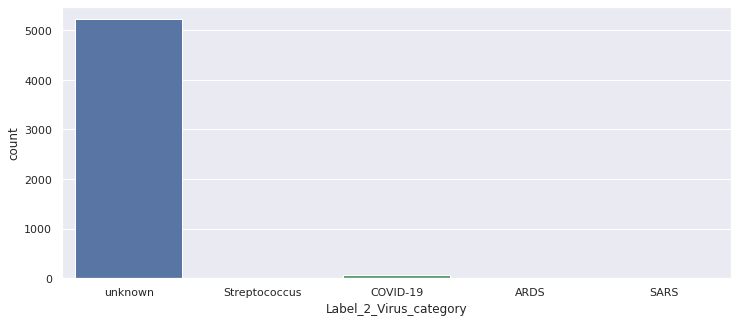

In [ ]:
plt.figure(figsize = (12, 5))
sns.countplot(train_data['Label_2_Virus_category']);

In [ ]:
train_img_dir = 'Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train'
sample_train_images = list(os.walk(train_img_dir))[0][2][:8]
sample_train_images = list(map(lambda x: os.path.join(train_img_dir, x), sample_train_images))
sample_train_images

['Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/person317_bacteria_1471.jpeg',
 'Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/NORMAL2-IM-0914-0001.jpeg',
 'Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/person416_bacteria_1840.jpeg',
 'Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0467-0001-0002.jpeg',
 'Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/person277_bacteria_1305.jpeg',
 'Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/person382_bacteria_1740.jpeg',
 'Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/person126_virus_255.jpeg',
 'Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/person130_virus_263.jpeg']

In [ ]:
train_img_dir = 'Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train' #-- Train Path
test_img_dir = 'Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test'   #-- Test Path

#-- Extract a sample
sample_train_images = list(os.walk(train_img_dir))[0][2][:8] #-- Path
sample_train_images = list(map(lambda x: os.path.join(train_img_dir, x), sample_train_images))

sample_test_images = list(os.walk(test_img_dir))[0][2][:8] #-- Path
sample_test_images = list(map(lambda x: os.path.join(test_img_dir, x), sample_test_images))

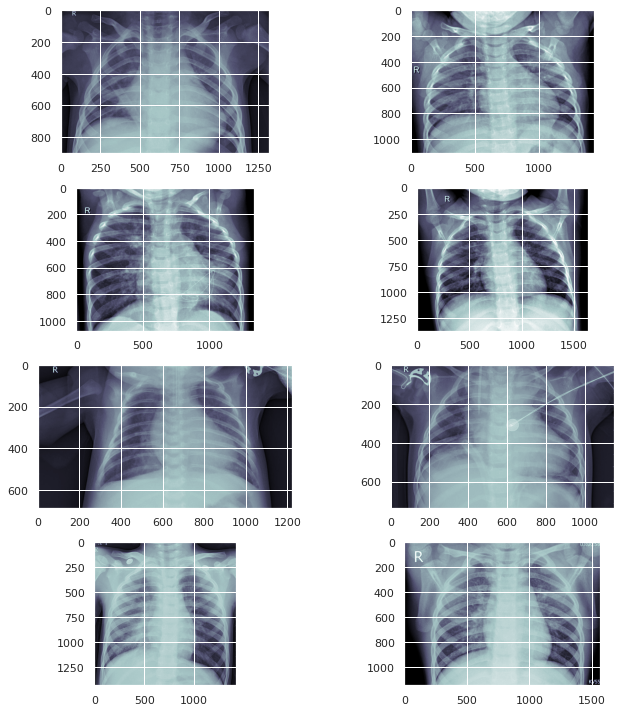

In [ ]:
plt.figure(figsize = (10, 10))

for iterator, filename in enumerate(sample_train_images):
    image = PIL.Image.open(filename)      #-- Read File
    plt.subplot(4, 2, iterator + 1)       #-- Subplot
    plt.imshow(image, cmap = plt.cm.bone) #-- Show Plot

plt.tight_layout()

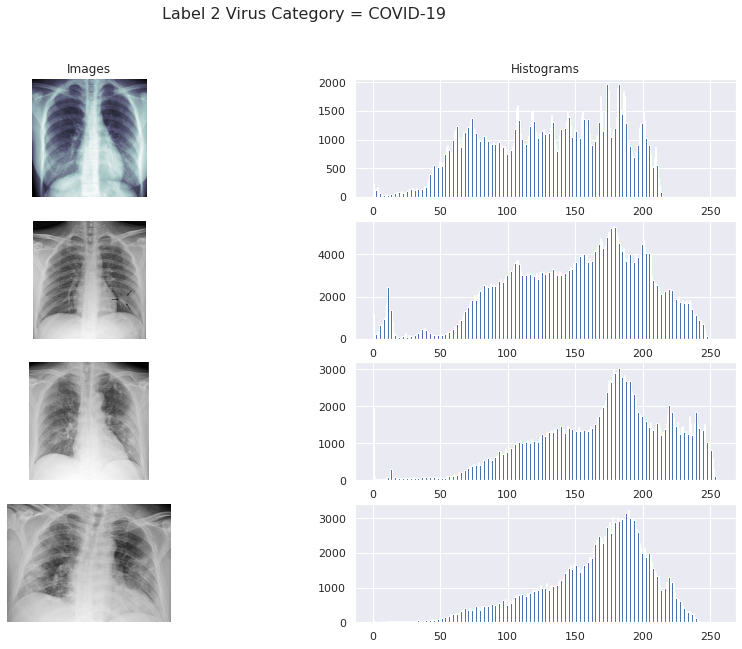

In [ ]:
fig, ax = plt.subplots(4, 2, figsize = (15, 10))

covid_path = train_data[train_data['Label_2_Virus_category'] == 'COVID-19']['X_ray_image_name'].values

sample_covid_path = covid_path[:4]
sample_covid_path = list(map(lambda x: os.path.join(train_img_dir, x), sample_covid_path))

for row, file in enumerate(sample_covid_path):
    image = plt.imread(file)
    ax[row, 0].imshow(image, cmap = plt.cm.bone)  #-- Show XRay
    ax[row, 1].hist(image.ravel(), 256, [0, 256]) #-- Show Hist
    ax[row, 0].axis('off')

    if row == 0:
        ax[row, 0].set_title('Images')           #-- Set Title for XRay
        ax[row, 1].set_title('Histograms')       #-- Set Title for Hist

fig.suptitle('Label 2 Virus Category = COVID-19', size = 16)
plt.show()

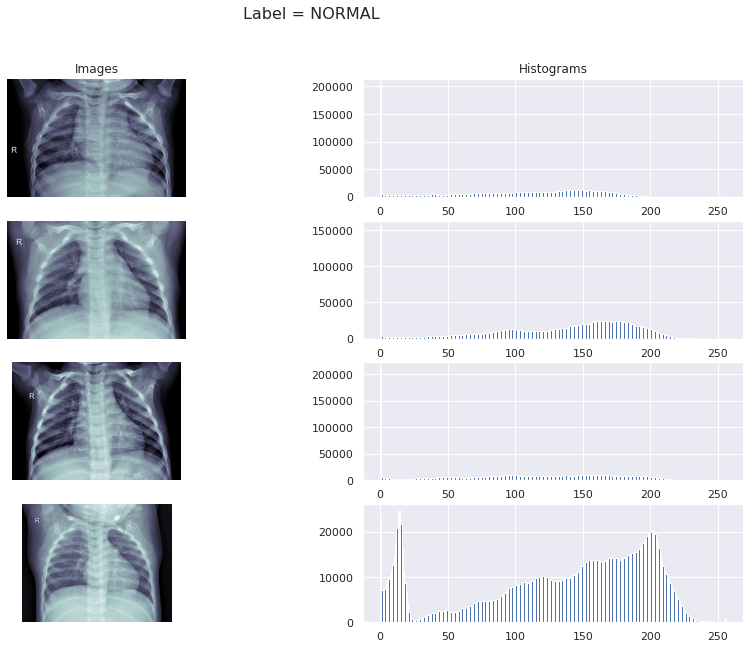

In [ ]:
fig, ax = plt.subplots(4, 2, figsize = (15, 10))


normal_path = train_data[train_data['Label'] == 'Normal']['X_ray_image_name'].values

sample_normal_path = normal_path[:4]
sample_normal_path = list(map(lambda x: os.path.join(train_img_dir, x), sample_normal_path))

for row, file in enumerate(sample_normal_path):
    image = plt.imread(file)
    ax[row, 0].imshow(image, cmap = plt.cm.bone)  #-- Show XRay
    ax[row, 1].hist(image.ravel(), 256, [0, 256]) #-- Show Hist
    ax[row, 0].axis('off')

    if row == 0:
        ax[row, 0].set_title('Images')            #-- Set Title for XRay
        ax[row, 1].set_title('Histograms')        #-- Set Title for Hist

fig.suptitle('Label = NORMAL', size=16)
plt.show()

# Augmentation

In [ ]:
train_data["Label"].value_counts()

Pnemonia    3944
Normal      1342
Name: Label, dtype: int64

In [ ]:
#-- Remove Pnuemonia with Unknown Value
final_train_data = train_data[(train_data['Label'] == 'Normal') | 
                              ((train_data['Label'] == 'Pnemonia') &
                               (train_data['Label_2_Virus_category'] == 'COVID-19'))]

#-- Add Target and Class Feature
final_train_data['class'] = final_train_data.Label.apply(lambda x: 'negative' if x == 'Normal' else 'positive') #-- Set Class
test_data['class'] = test_data.Label.apply(lambda x: 'negative' if x == 'Normal' else 'positive')               #-- Set Class

final_train_data['target'] = final_train_data.Label.apply(lambda x: 0 if x == 'Normal' else 1)                  #-- Set Target
test_data['target'] = test_data.Label.apply(lambda x: 0 if x == 'Normal' else 1)                                #-- Set Target

#-- Extract Important Features
final_train_data = final_train_data[['X_ray_image_name', 'class', 'target', 'Label_2_Virus_category']]
final_test_data = test_data[['X_ray_image_name', 'class', 'target']]

test_data['Label'].value_counts()

Pnemonia    390
Normal      234
Name: Label, dtype: int64

In [ ]:
print(final_train_data["target"].value_counts())
final_train_data.head()

0    1342
1      58
Name: target, dtype: int64


,X_ray_image_name,class,target,Label_2_Virus_category
0,IM-0128-0001.jpeg,negative,0,unknown
1,IM-0127-0001.jpeg,negative,0,unknown
2,IM-0125-0001.jpeg,negative,0,unknown
3,IM-0122-0001.jpeg,negative,0,unknown
4,IM-0119-0001.jpeg,negative,0,unknown


In [ ]:
print(final_test_data["target"].value_counts())
final_test_data.head()

1    390
0    234
Name: target, dtype: int64


,X_ray_image_name,class,target
5286,IM-0021-0001.jpeg,negative,0
5287,IM-0019-0001.jpeg,negative,0
5288,IM-0017-0001.jpeg,negative,0
5289,IM-0016-0001.jpeg,negative,0
5290,IM-0015-0001.jpeg,negative,0


In [ ]:
#-- ImageDataGenerator for Augmentation
datagen = ImageDataGenerator(shear_range = 0.2, #-- Cut
                             zoom_range = 0.2)  #-- Zooming

#-- Function for Reading an Image
def read_img(filename, size, path):
    imm = tf.keras.preprocessing.image.load_img(os.path.join(path, filename), target_size = size)
    
    imm = img_to_array(imm) / 255 #-- Convert Image to Array
    return imm

Augmenti labeled images with COVID-19 for balancing the data

In [ ]:
corona_df = final_train_data[final_train_data['Label_2_Virus_category'] == 'COVID-19']
with_corona_augmented = []

#-- Function for Augmentation
def augment(name):
    imm = read_img(name, (255,255), train_img_dir) #-- Read Image
    
    i = 0
    for batch in tqdm(datagen.flow(tf.expand_dims(imm, 0), batch_size = 32)):
        with_corona_augmented.append(tf.squeeze(batch).numpy())
        
        if i == 20:
          break
        i = i + 1

corona_df['X_ray_image_name'].apply(augment) #-- Apply Augmentation

Extract images from Train and Test and convert as array.

In [ ]:
train_arrays = [] 
final_train_data['X_ray_image_name'].apply(lambda x: train_arrays.append(read_img(x, (255, 255), train_img_dir)))

test_arrays = []
final_test_data['X_ray_image_name'].apply(lambda x: test_arrays.append(read_img(x, (255, 255), test_img_dir)))

In [ ]:
len(train_arrays)

1400

Concatenation of traning labels with augmented

In [ ]:
y_train = np.concatenate((np.int64(final_train_data['target'].values), #-- Training labels
                          np.ones(len(with_corona_augmented),          #-- Augmented Labels
                                  dtype = np.int64)))

Convert Data to Tensors

In [ ]:
train_tensors = tf.convert_to_tensor(np.concatenate((np.array(train_arrays),
                                                     np.array(with_corona_augmented))))
test_tensors  = tf.convert_to_tensor(np.array(test_arrays))

y_train_tensor = tf.convert_to_tensor(y_train)
y_test_tensor = tf.convert_to_tensor(final_test_data['target'].values)

train_dataset = tf.data.Dataset.from_tensor_slices((train_tensors,
                                                    y_train_tensor))
test_dataset = tf.data.Dataset.from_tensor_slices((test_tensors,
                                                   y_test_tensor))

In [ ]:
test_arrays[0].shape

(255, 255, 3)

In [ ]:
BATCH_SIZE = 16
BUFFER = 1000

train_batches = train_dataset.shuffle(BUFFER).batch(BATCH_SIZE)
test_batches = test_dataset.batch(BATCH_SIZE)

In [ ]:
len(with_corona_augmented)

1218

In [ ]:
pd.DataFrame(y_train).value_counts()

0    1342
1    1276
dtype: int64

In [ ]:
final_test_data['target'].value_counts()

1    390
0    234
Name: target, dtype: int64

# ResNet 50

Set false trainable method of Convolutional Layer because we don't want to mess up the pretrained weights of the model.

In [ ]:
INPUT_SHAPE = (255, 255, 3) #-- Input Shape

#-- Pre Trained Model
base_model = tf.keras.applications.ResNet50(input_shape = INPUT_SHAPE, #-- 
                                            include_top = False,       #-- 
                                            weights = 'imagenet')      #-- 

base_model.trainable = False

Let's Verify the Output Shape

In [ ]:
for i, l in train_batches.take(1):
    pass
base_model(i).shape

TensorShape([16, 8, 8, 2048])

## Fine Tuning

In [ ]:
model = Sequential()
model.add(base_model)                    #-- ResNet 50
model.add(GlobalAveragePooling2D())      #-- Average Pooling
model.add(Dense(128))                    #-- Dense Layer with 128 Neurons
model.add(Dropout(0.2))                  #-- For Preventing Overfitting
model.add(Dense(1,
                activation = 'sigmoid')) #-- Output Layer for Classification

Add an Earlystopping Callback to stop the training if the model is not learning anymore.

In [ ]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', #-- Early Stop To Validation Loss
                                             patience = 2)         #-- How Many Steps

model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy', #-- Loss Function
              metrics = ['accuracy'])       #-- Metric to Train

## Training

In [ ]:
history = model.fit(train_batches,                  #-- Train to Fit
                    epochs = 10,                    #-- Number of Epochs
                    validation_data = test_batches, #-- Validation
                    callbacks = [callbacks])        #-- Early Stop

Epoch 1/10
164/164 [==============================] - 15s 72ms/step - loss: 0.4847 - accuracy: 0.8380 - val_loss: 0.5373 - val_accuracy: 0.7516
Epoch 2/10
164/164 [==============================] - 11s 68ms/step - loss: 0.2968 - accuracy: 0.9124 - val_loss: 0.5360 - val_accuracy: 0.7436
Epoch 3/10
164/164 [==============================] - 11s 67ms/step - loss: 0.2690 - accuracy: 0.9196 - val_loss: 0.5668 - val_accuracy: 0.7548
Epoch 4/10
164/164 [==============================] - 11s 68ms/step - loss: 0.2120 - accuracy: 0.9453 - val_loss: 0.6599 - val_accuracy: 0.7436


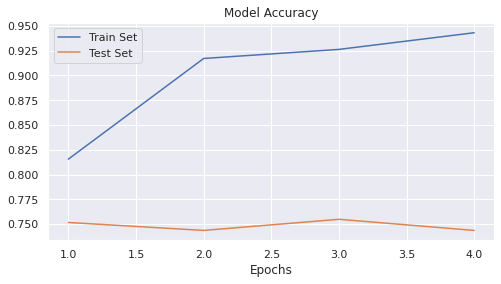

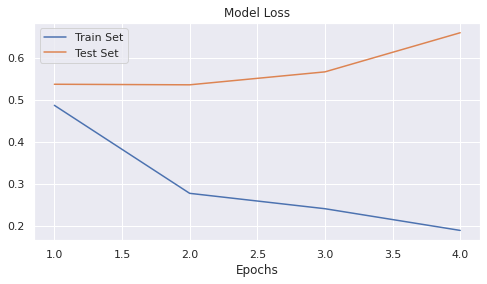

In [ ]:
acc = history.history['accuracy']         #-- Train Accuracy
val_acc = history.history['val_accuracy'] #-- Validation Accuracy
loss = history.history['loss']            #-- Loss Function
val_loss = history.history['val_loss']    #-- Validation Loss
epochs_range = range(1, 4 + 1)            #-- Number of Epochs

#-- Model Accuracy Loss
plt.figure(figsize = (8, 4))
plt.plot(epochs_range,
         acc,
         label = 'Train Set')
plt.plot(epochs_range,
         val_acc,
         label = 'Test Set')

plt.legend(loc = "best")
plt.xlabel('Epochs')
plt.title('Model Accuracy')
plt.show()

#-- Model Loss Plot
plt.figure(figsize = (8,4))
plt.plot(epochs_range,
         loss,
         label = 'Train Set')
plt.plot(epochs_range,
         val_loss,
         label = 'Test Set')
plt.legend(loc = "best")
plt.xlabel('Epochs')
plt.title('Model Loss')
plt.show()

## Prediction

In [ ]:
pred = model.predict_classes(np.array(test_arrays)) #-- Predict Class Data (Test)

#-- Classification Report
print(classification_report(test_data['target'], #-- Test 
                            pred.flatten()))     #-- Prediction

              precision    recall  f1-score   support

           0       0.63      0.79      0.70       234
           1       0.85      0.72      0.78       390

    accuracy                           0.74       624
   macro avg       0.74      0.75      0.74       624
weighted avg       0.76      0.74      0.75       624



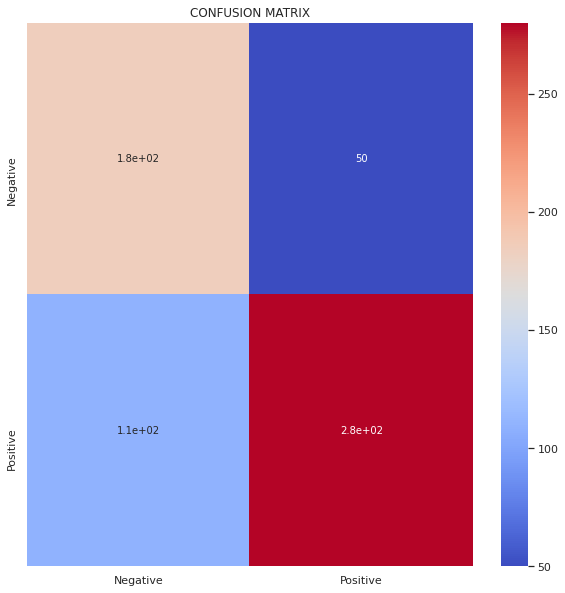

In [ ]:
#-- Confusion Matrix
con_mat = confusion_matrix(test_data['target'], #-- Test 
                           pred.flatten())      #-- Predicition

#-- Plot the Confusion Matrix
plt.figure(figsize = (10, 10))
plt.title('CONFUSION MATRIX')

sns.heatmap(con_mat,
            cmap = 'coolwarm',
            yticklabels = ['Negative', 'Positive'], #-- Y Labels
            xticklabels = ['Negative', 'Positive'], #-- X Labels
            annot = True);

In [ ]:
#@title Saving Model {display-mode: "form"}

model.save("ResNet50.h5")

!cp "ResNet50.h5" "/content/gdrive/MyDrive/Università/Data Science/2° Anno/Digital Signal and Image Management/Progetto DSIM/ResNet50.h5"

# EfficientnetB7

In [ ]:
model_B7 = tf.keras.applications.EfficientNetB7(weights = 'imagenet',      #-- 
                                                input_shape = INPUT_SHAPE, #-- Input Shape (255, 255, 3)
                                                include_top = False)       #-- Not 
model_B7.trainable = False

258080768/258076736 [==============================] - 9s 0us/step


## Fine Tuning

In [ ]:
model_EB7 = Sequential()
model_EB7.add(base_model)                #-- ResNet 50
model_EB7.add(GlobalAveragePooling2D())  #-- Average Pooling
model_EB7.add(Dense(128))                #-- Dense Layer with 128 Neurons
model_EB7.add(Dropout(0.2))              #-- For Preventing Overfitting
model_EB7.add(Dense(1,
                activation = 'sigmoid')) #-- Output Layer for Classification

In [ ]:
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy', #-- Loss Function
              metrics = ['accuracy'])       #-- Metric to Train

## Training

In [ ]:
history_EB7 = model.fit(train_batches,                  #-- Train to Fit
                        epochs = 10,                    #-- Number of Epochs
                        validation_data = test_batches, #-- Validation
                        callbacks = [callbacks])        #-- Early Stop

Epoch 1/10
164/164 [==============================] - 14s 70ms/step - loss: 0.7693 - accuracy: 0.7932 - val_loss: 0.5376 - val_accuracy: 0.7163
Epoch 2/10
164/164 [==============================] - 11s 65ms/step - loss: 0.3422 - accuracy: 0.9113 - val_loss: 0.5793 - val_accuracy: 0.7099
Epoch 3/10
164/164 [==============================] - 11s 65ms/step - loss: 0.3276 - accuracy: 0.9075 - val_loss: 0.5939 - val_accuracy: 0.7516


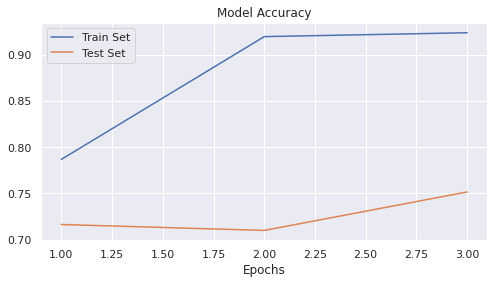

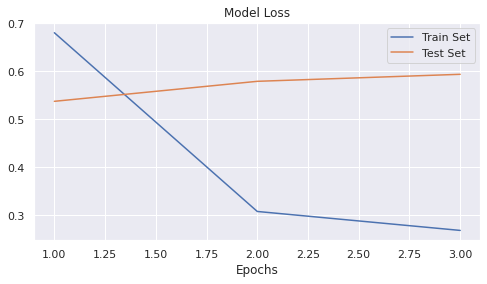

In [ ]:
acc = history_EB7.history['accuracy']         #-- Train Accuracy
val_acc = history_EB7.history['val_accuracy'] #-- Validation Accuracy
loss = history_EB7.history['loss']            #-- Loss Function
val_loss = history_EB7.history['val_loss']    #-- Validation Loss
epochs_range = range(1, 3 + 1)                #-- Number of Epochs

#-- Model Accuracy Loss
plt.figure(figsize = (8, 4))
plt.plot(epochs_range,
         acc,
         label = 'Train Set')
plt.plot(epochs_range,
         val_acc,
         label = 'Test Set')

plt.legend(loc = "best")
plt.xlabel('Epochs')
plt.title('Model Accuracy')
plt.show()

#-- Model Loss Plot
plt.figure(figsize = (8,4))
plt.plot(epochs_range,
         loss,
         label = 'Train Set')
plt.plot(epochs_range,
         val_loss,
         label = 'Test Set')
plt.legend(loc = "best")
plt.xlabel('Epochs')
plt.title('Model Loss')
plt.show()

## Prediction

In [ ]:
pred = model_EB7.predict_classes(np.array(test_arrays)) #-- Predict Class Data (Test)

#-- Classification Report
print(classification_report(test_data['target'], #-- Test 
                            pred.flatten()))     #-- Prediction

              precision    recall  f1-score   support

           0       0.64      0.76      0.70       234
           1       0.84      0.75      0.79       390

    accuracy                           0.75       624
   macro avg       0.74      0.75      0.74       624
weighted avg       0.77      0.75      0.75       624



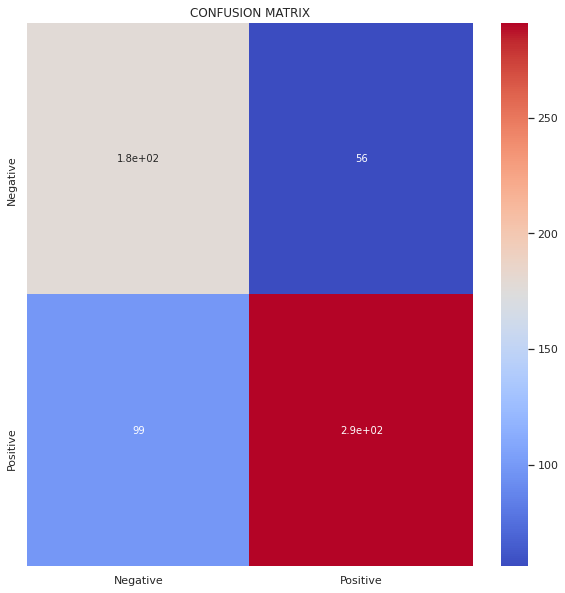

In [ ]:
con_mat = confusion_matrix(test_data['target'], #-- Test
                           pred.flatten())      #-- Prediction

#-- Plot the Confusion Matrix
plt.figure(figsize = (10, 10))
plt.title('CONFUSION MATRIX')
sns.heatmap(con_mat, cmap = 'coolwarm',
            yticklabels = ['Negative', 'Positive'],  #-- Y Labels
            xticklabels = ['Negative', 'Positive'],  #-- X Labels
            annot = True);

In [ ]:
#@title Saving Model {display-mode: "form"}

model_EB7.save("EfficientnetB7.h5")

!cp "EfficientnetB7.h5" "/content/gdrive/MyDrive/Università/Data Science/2° Anno/Digital Signal and Image Management/Progetto DSIM/EfficientnetB7.h5"

# Automated COVID-19 Detection

In [ ]:
def covid_detection(pred_array):

  if pred_array == 1:
    print("Oh Man! Your Patient is Positive to COVID-19! Wear a mask")
  else:
    print("Your Patient is Negative to COVID-19!")

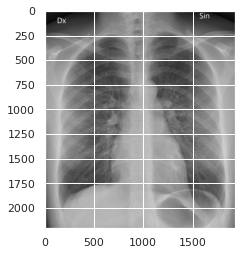

In [ ]:
path = 'xray_1.jpg'
im = cv.imread(path)
plt.imshow(im)

In [ ]:
img = image.load_img(path, target_size = (255, 255))
img_array = image.img_to_array(img) / 255
img_batch = np.expand_dims(img_array, axis = 0)

In [ ]:
test_image = model.predict_classes(np.array(img_batch))
covid_detection(test_image)

Oh Man! Your Patient is Positive to COVID-19! Wear a mask
